# Random mesaurements based manuel wire cutting implementation using Pennylane for dividing a GHZ quantumcircuit with implementation

* Author: Michel Meulen
* Date: 01-04-2025
* Contact: michel.meulen@tno.nl
-----------------------------------
This notebook illustrates a method for partitioning a Greenberger-Horne-Zeilinger (GHZ) quantum circuit, with an arbitrary number of qubits, into manageable subcircuits using the randomised-measurements-based wire cutting technique. The notebook then outlines how to reconstruct the measurement outcomes of the full circuit by appropriately combining the results obtained from measuring these subcircuit variants. The implementation is based on this paper: [Fast quantum circuit cutting with randomized measurements](https://arxiv.org/pdf/2207.14734) and tutorial: [Quantum Circuit Cutting](https://pennylane.ai/qml/demos/tutorial_quantum_circuit_cutting) created by Xanadu - Pennylane.

In [145]:
# General parameters
NUMBER_OF_QUBITS = 5  # Min: 2,   Recommended: 5,       Max: 10
NUMBER_OF_CUTS = 1  # Min: 1,   Recommended: 3,       Max: NUMBER_OF_QUBITS - 1

# Subcircuit parameters
SHOTS_BUDGET = 1000  # Min: 100,   Recommended: 1000,    Max: 10000
SUB_CIRCUIT_ITERATIONS = SHOTS_BUDGET // 50  # Min: 10,   Recommended: 20,      Max: 100
USE_QUANTUM_TELEPORTATION = True
USE_RANDOM_ROTATION = False  # If False, use random Clifford gates; if True, use random rotation gates

Import all neccessary libraries used in this notebook:

In [146]:
from GHZ_random_measurements import GHZRandomWireCut
from quantum_channel import QuantumChannel

# Utility functions
from quantum_utils import QuantumUtils as qu
from quantum_wire_cutting import QuantumWireCutUtils as qwcu

# Circuit configurations required for custom gate configuration:
from circuit_configurations.circuit_configuration import CircuitConfiguration
from circuit_arguments.circuit_gate_argument import CircuitGateArgument
from circuit_gate import CircuitGate

# Circuit configurations for creating random gates configuration:
from circuit_configurations.circuit_random_gates_configuration import RandomCircuitGatesConfiguration

# Circuit configurations for creating random rotations and angles configuration:
from circuit_configurations.circuit_random_rotations_configuration import RandomCircuitRotationsConfiguration

(Optional & advanced) It is also possible to add a configuration to the circuit. With this configuration you can add single qubit gates 
on specific qubits to make the GHZ quantum circuit more interesting. You can choose between three different types of configurations which add certain gates in the GHZ quantum circuit. The configurations are: 
* Custom qubit gates        (X, Y, Z, S)
* Random qubit gates        (X, Y, Z, S)
* Random rotation gates     (RX , RY, RZ)

In [147]:
# If you want to run the GHZ quantum circuit with no additional extra gates, you can use this example:
CIRCUIT_CONFIG = None

# If you want to create custom gates configuration, you can use this example:
# CIRCUIT_CONFIG = CircuitConfiguration([
#     CircuitGateArgument(1, CircuitGate.X),
#     CircuitGateArgument(2, CircuitGate.Y),
#     CircuitGateArgument(3, CircuitGate.Z),
#     CircuitGateArgument(4, CircuitGate.S)
# ])

# Due the use of random and the sake of repoducibility, we are using a fixed seed
# qu.SetSeed(42)

# If you want to make a random configuration of gates, you can use this example:
# CIRCUIT_CONFIG = RandomCircuitGatesConfiguration(NUMBER_OF_QUBITS, NUMBER_OF_QUBITS)

# If you want to make a random configuration of random rotation gates and angles, you can use this example:
# CIRCUIT_CONFIG = RandomCircuitRotationsConfiguration(NUMBER_OF_QUBITS, NUMBER_OF_QUBITS)s

With the parameters, defined above this text, the 'GHZRandomWireCut' object is contstructed. It functions as a high-level object this notebook will access to run the experiment.

In [148]:
exp = GHZRandomWireCut(
    NUMBER_OF_QUBITS, NUMBER_OF_CUTS, SHOTS_BUDGET, SUB_CIRCUIT_ITERATIONS, USE_QUANTUM_TELEPORTATION, USE_RANDOM_ROTATION, CIRCUIT_CONFIG
)

print(exp.originalCircuit.ToString())

exp.originalCircuit.Visualise()
orgProbs = exp.originalCircuit.Run()

for subcircuit in exp.subCircuits:
    print(subcircuit)

Original circuit: Original with 5 qubits; shots: 1000 and 
None
Original GHZ state quantum circuit:
0: ──H─╭●──────────┤ ╭Probs
1: ────╰X─╭●───────┤ ├Probs
2: ───────╰X─╭●────┤ ├Probs
3: ──────────╰X─╭●─┤ ├Probs
4: ─────────────╰X─┤ ╰Probs


Subcircuit: 0 with 3 qubits; has position BEGIN and 50 shots and Contribution: from: 0 to: 2 length: 2 of total: 5; bitstring: [00]XXX
Subcircuit: 1 with 3 qubits; has position END and 50 shots and Contribution: from: 2 to: 5 length: 3 of total: 5; bitstring: XX[000]


### Run the subcircuits to obtain the right data to reconstruct the probability 

In [149]:
exp.VisualiseSubcircuit(quantumChannel=QuantumChannel.RANDOM_CLIFFORD)
exp.VisualiseSubcircuit(quantumChannel=QuantumChannel.DEPOLARIZATION)

0: ──H─╭●─────────┤↗│  │0⟩───────────────────────────────────X──Z──H─╭●─────┤↗│  │0⟩─────────────────────┤             
1: ────╰X─╭●───────║────────┤↗│  │0⟩─╭X──H─────────┤↗│  │0⟩──║──║────╰X─╭●───║────────┤↗│  │0⟩───────────┤             
2: ───────╰X──H†───║─────────║───────╰●──┤↗│  │0⟩───║────────║──║───────╰X───║─────────║────────┤↗│  │0⟩─┤             
                   ╚═════════║════════════║═════════║════════║══║════════════║═════════║═════════║═══════╡ ╭Counts[MCM]
                             ╚════════════║═════════║════════║══║════════════║═════════║═════════║═══════╡ ├Counts[MCM]
                                          ╚═════════║════════╝  ║            ║         ║         ║         │           
                                                    ╚═══════════╝            ║         ║         ║         │           
                                                                             ╚═════════║═════════║═══════╡ ├Counts[MCM]
                                        

Compared to Pauli wire cutting, the randomized measurement circuit cutting relies on running the same subcircuit multiple times. Each iteration creates a random Clifford circuit, for channel 0, and random basis state, for channel 1. 

Number of shots for channel 1:  20
Number of shots for channel 0:  30
Running subcircuit:  20  times each channel 0 having:  30  shots and channel 1 having:  20  shots
Results of channel 0:  [np.int64(318), 0, 0, 0, 0, 0, 0, np.int64(6), 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, np.int64(9), 0, 0, 0, 0, 0, 0, np.int64(267)]
Results of channel 1:  [np.int64(89), 0, 0, 0, 0, 0, 0, np.int64(113), 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, np.int64(97), 0, 0, 0, 0, 0, 0, np.int64(101)]


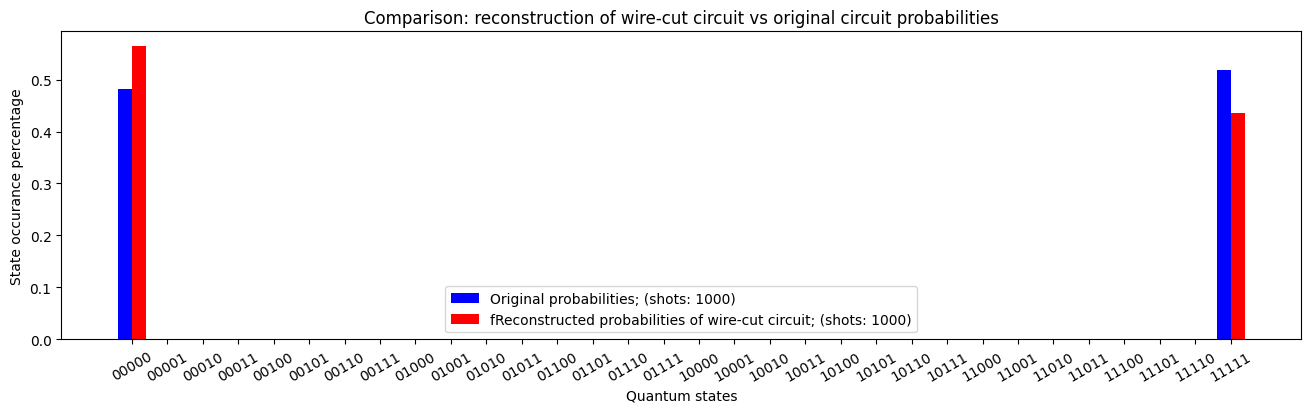

In [150]:
results = exp.Run(True)
results = exp.MergeAndNormalize(results[0], results[1])
dataLabels = [f"Original probabilities; (shots: {1000})", f"fReconstructed probabilities of wire-cut circuit; (shots: {SHOTS_BUDGET})"]
dataSets = [orgProbs, results]
title = "Comparison: reconstruction of wire-cut circuit vs original circuit probabilities"

qu.ProbabilitesToBarChart(dataLabels=dataLabels, probabilities=dataSets, title=title)